## Visualize Results

### Imports

In [1]:
import sys,os
sys.path.append('../src')

import glob
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import lr_model
from importlib import reload
reload(lr_model)
from lr_model import LinearModel
from utils import *
from data import SharpsDataModule,SharpsDataset
from dataset import SHARPdataset
from autoencoder import SharpEmbedder
from probability_calibration import probability_calibration
import wandb

/home/kvandersande/miniconda3/envs/fforecast/lib/python3.9/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/home/kvandersande/miniconda3/envs/fforecast/lib/python3.9/site-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedba

Device: cuda:0


### Load data

In [42]:
df = pd.read_csv('../data/index_sharps.csv')
run = 'jb0drfqt' #'jb0drfqt'
latent_dim = 100

In [43]:
embeddings = []
for embedding_file in glob.glob('../data/embeddings/run-'+run+'/embeddings[a-zA-z][a-zA-z]*.csv'):
    embeddings.append(pd.read_csv(embedding_file))
df_embeddings = pd.concat(embeddings)
df_embeddings.rename(columns={'filename':'file'},inplace=True)
df_embeddings = df.merge(df_embeddings,how='inner',on='file')
df_embeddings.to_csv('../data/embeddings/run-'+run+'/embeddings.csv',index=False)

### Train LR model

In [50]:
data_file = '../data/embeddings/run-'+run+'/embeddings.csv'
flare_thresh = 1e-5
window = 24

feats = ['embed'+str(i) for i in range(latent_dim)]    # SHARPs parameters
# feats = []
feats.extend(['naxis1','naxis2'])
# feats = ['lat_fwt','lon_fwt','area_acr','usflux','meangam','meangbt','meangbz','meangbh',
#          'meanjzd','totusjz','meanalp','meanjzh','totusjh','absnjzh','savncpp','meanpot',
#          'totpot','meanshr','shrgt45','r_value']    # SHARPs parameters
    

                      MSE       BSS       APS      Gini       TSS       HSS  \
Model 0          0.028841  0.222872  0.399488  0.718720  0.171776  0.282498   
Model 1          0.029428  0.207045  0.378540  0.711166  0.182218  0.293241   
Model 2          0.029541  0.204004  0.373440  0.715679  0.170884  0.276186   
Model 3          0.030177  0.186872  0.357056  0.679500  0.160219  0.263491   
Model 4          0.029330  0.209693  0.381857  0.720859  0.155332  0.260016   
Ensemble-Median  0.029120  0.215354  0.388004  0.723853  0.166221  0.274565   

                      TPR       FPR  
Model 0          0.172222  0.000446  
Model 1          0.183333  0.001115  
Model 2          0.172222  0.001338  
Model 3          0.161111  0.000892  
Model 4          0.155556  0.000223  
Ensemble-Median  0.166667  0.000446  


/home/kvandersande/Documents/Projects/sharps-embeddings/notebooks/../src/utils.py:181: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string ".-" (-> marker='.'). The keyword argument will take precedence.
  ax.plot(prob_pred,prob_true,'.-',label=label,**kwargs)


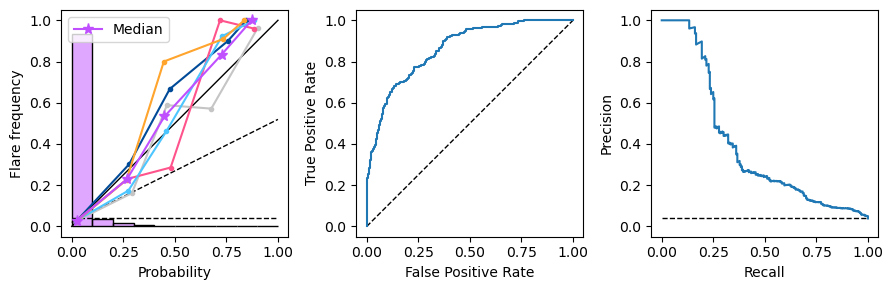

In [51]:
reload(lr_model)
from lr_model import LinearModel

results = {}
train_frac = 1
metrics = []
for val_split in range(5):
    model = LinearModel(data_file=data_file,window=window,flare_thresh=flare_thresh,
                        val_split=val_split,features=feats,max_iter=300,
                        # hidden_layer_sizes=(20,)
                        )
    model.prepare_data()
    model.setup()
    if train_frac != 1:
        subsample_files,_ = diverse_sampler(model.df_train['file'].to_list(),
                                            model.X_train,
                                            n=int(train_frac*len(model.df_train)))
        model.subsample_trainset(subsample_files)
    model.train()
    ypred = model.test(model.X_pseudotest,model.df_pseudotest['flare'])
    y = model.df_pseudotest['flare']
    ypred_trainval = model.test(np.append(model.X_train,model.X_val,axis=0))
    ytrainval = np.append(model.y_train,model.df_val['flare'])
    # calibrator = probability_calibration(ypred_trainval,ytrainval,ypred)
    # ypred_cal = np.array(calibrator.calibrateProbability(20))

    results['ypred'+str(val_split)] = ypred
    # results['yprob'+str(val_split)] = ypred_cal
    results['ytrue'] = y
    metrics.append(print_metrics(ypred,y,print_results=False))
    # print_metrics(ypred_cal,y)

df_results = pd.DataFrame(results)
df_results.insert(0,'filename',model.df_pseudotest['file'])
df_results['ypred_median'] = df_results.filter(regex='ypred[0-9]').median(axis=1)
# df_results['yprob_median'] = df_results.filter(regex='yprob[0-9]').median(axis=1)
metrics.append(print_metrics(df_results['ypred_median'],df_results['ytrue'],print_results=False))
# print_metrics(df_results['yprob_median'],df_results['ytrue'])

metrics = pd.DataFrame(data=metrics,columns=['MSE','BSS','APS','Gini','TSS','HSS','TPR','FPR'],
                       index=['Model 0','Model 1','Model 2','Model 3','Model 4','Ensemble-Median'])
print(metrics)
metrics.to_csv('metrics.csv')
plot_performance(df_results,cal='ypred')

### View reconstructions

In [16]:
api = wandb.Api()
model = load_model('kierav/sharps-embeddings/model-'+run+':latest',SharpEmbedder,api)

Loading model checkpoint from  kierav/sharps-embeddings/model-megbd3wu:latest


wandb:   1 of 1 files downloaded.  


In [17]:
files = glob.glob('../data/sharps_hdf5/*.h5')
files = [file.replace('../data/','/d0/kvandersande/') for file in files]
df_test = df[df['file'].isin(files)]
test_dataset = SHARPdataset('../data/sharps_hdf5',image_size=128)
(image,filename) = test_dataset[-1]
img_out = model.forward(image).detach().numpy()

Text(0.5, 0.98, 'Latent 20 - ../data/sharps_hdf5/hmi.sharp_cea_720s.8882.20221212_154800_TAI.h5')

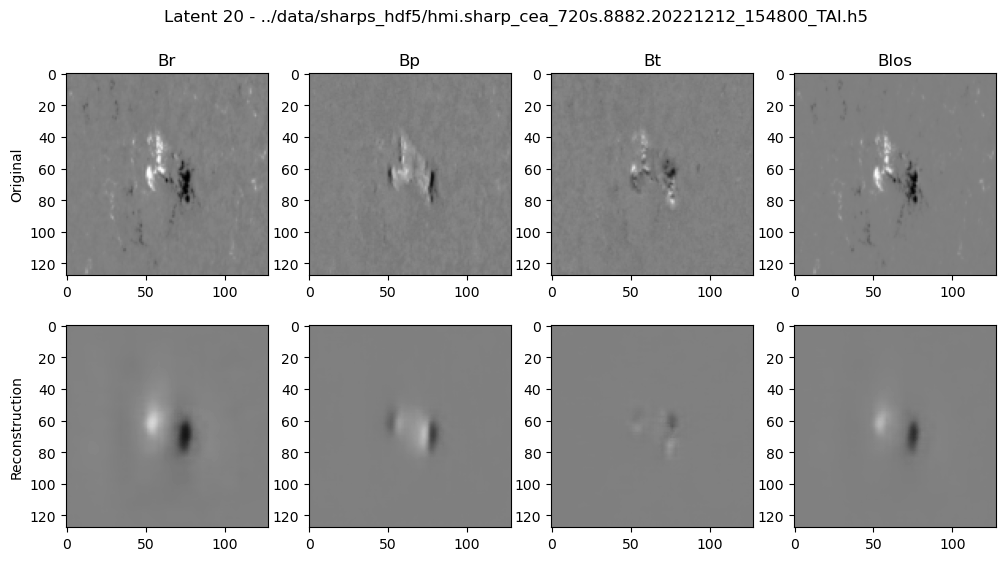

In [18]:
fig,ax = plt.subplots(2,4,figsize=(12,6))
for j in range(4):
    ax[0,j].imshow(image[0,j,:,:],cmap='gray',vmin=0,vmax=1)
    ax[1,j].imshow(img_out[0,j,:,:],cmap='gray',vmin=0,vmax=1)
ax[0,0].set_ylabel('Original')
ax[1,0].set_ylabel('Reconstruction')
ax[0,0].set_title('Br')
ax[0,1].set_title('Bp')
ax[0,2].set_title('Bt')
ax[0,3].set_title('Blos')
plt.suptitle('Latent '+str(latent_dim)+ ' - '+filename)